In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)

In [2]:
FEATURES_PATH = '/export/livia/home/datasets/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = '/export/livia/home/datasets/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = '/export/livia/home/datasets/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données

In [3]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, True)

### 1. 3 Initialisation des sous-groupes

In [4]:
train_images_gender, train_labels_gender, train_images_race, train_labels_race = RAFDB_subgroups_init()

### 1. 4. 1 Séparation des sous-groupes (pour la visualisation)

In [5]:
train_images_gender['male'] = np.array(raf_db['images_gender']['male'])
train_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
train_images_gender['female'] = np.array(raf_db['images_gender']['female'])
train_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])

train_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
train_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
train_images_race['asian'] = np.array(raf_db['images_race']['asian'])
train_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
train_images_race['african'] = np.array(raf_db['images_race']['african'])
train_labels_race['african'] = np.array(raf_db['labels_race']['african'])

### 1. 4. 2 Reconstruction de la base de données

In [6]:
# Combine the subgroups into a single dataset
train_images = np.concatenate((train_images_gender['male'], train_images_gender['female'], train_images_race['caucasian'], train_images_race['asian'], train_images_race['african']), axis=0)
train_labels = np.concatenate((train_labels_gender['male'], train_labels_gender['female'], train_labels_race['caucasian'], train_labels_race['asian'], train_labels_race['african']), axis=0)

## 2. Augmentation de la base de données

In [7]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create an instance of the ImageDataGenerator class with the desired data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20, # Rotate images randomly by 20 degrees
    width_shift_range=0.1, # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the height
    shear_range=0.2, # Apply shearing transformation with a maximum shear of 20%
    zoom_range=0.2, # Randomly zoom in and out by 20%
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest' # Fill any empty pixels with the nearest value
)

# Fit the ImageDataGenerator to the training data
datagen.fit(train_images)

## 3. Apprentissage de VGG19 avec fine tuning et augmentation

In [8]:
# Instantiate the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# Add a global average pooling layer and a dense layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top 10 layers (fine tuning)
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
batch_size = 32
steps_per_epoch = train_images.shape[0] // batch_size
validation_steps = val_images.shape[0] // batch_size

train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size, shuffle=True)
val_generator = datagen.flow(val_images, val_labels, batch_size=batch_size, shuffle=False)

In [9]:
# Define checkpoint and early stopping callbacks
checkpoint_dir = './checkpointsv2'
checkpoint_file = checkpoint_dir + '/best_augmented_VGG19.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [10]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=300, validation_data=val_generator, validation_steps=validation_steps, callbacks=[checkpoint, early_stop], verbose=1)

Epoch 1/300
613/613 [==============================] - 389s 623ms/step - loss: 1.4428 - accuracy: 0.4781 - val_loss: 0.9819 - val_accuracy: 0.6583
Epoch 2/300
613/613 [==============================] - 392s 639ms/step - loss: 0.9211 - accuracy: 0.6845 - val_loss: 0.7811 - val_accuracy: 0.7237
Epoch 3/300
613/613 [==============================] - 387s 631ms/step - loss: 0.7025 - accuracy: 0.7563 - val_loss: 0.7213 - val_accuracy: 0.7386
Epoch 4/300
613/613 [==============================] - 383s 626ms/step - loss: 0.5666 - accuracy: 0.8013 - val_loss: 0.6326 - val_accuracy: 0.7839
Epoch 5/300
613/613 [==============================] - 373s 609ms/step - loss: 0.4719 - accuracy: 0.8317 - val_loss: 0.5678 - val_accuracy: 0.8000
Epoch 6/300
613/613 [==============================] - 378s 617ms/step - loss: 0.3956 - accuracy: 0.8572 - val_loss: 0.4965 - val_accuracy: 0.8290
Epoch 7/300
613/613 [==============================] - 380s 620ms/step - loss: 0.3385 - accuracy: 0.8848 - val_loss: 0

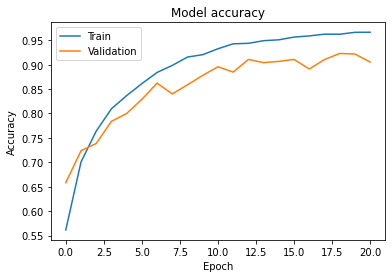

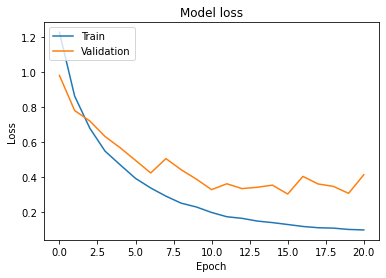

In [11]:
# Plot the accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()